## Import Packages

In [1]:
# By: Darren Upton
# Modeled on Code By: Kishan Rajput

import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Dropout
from tensorflow.keras import datasets, layers, models
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import warnings
import pickle
import seaborn as sns

#Stuff for ML
import sklearn
from sklearn.model_selection import GridSearchCV
from sklearn import tree
import random
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report,confusion_matrix,ConfusionMatrixDisplay
from sklearn.metrics import auc, roc_curve

from keras import backend as K

from matplotlib.colors import LogNorm


Matplotlib created a temporary config/cache directory at /tmp/matplotlib-ua1d22pn because the default path (/home/jovyan/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


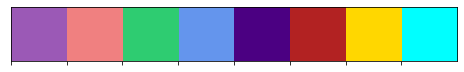

In [2]:
best_colors = ["#9b59b6",
               "lightcoral",
               "#2ecc71","cornflowerblue","indigo",#"darkorange",
               "firebrick","gold",
               "cyan"#"magenta"
              ]
sns.set_palette(sns.color_palette(best_colors))
sns.palplot(sns.color_palette(best_colors))

## Import Data

In [3]:
%%time

#Full
raw_sim_df = pd.read_csv("Sim_CSV/Sim_Pencil_AllEvents_TID1.csv")
raw_bkg_df = pd.read_csv("Sim_CSV/Sim_Pencil_Bkg.csv")

#Cher Arrays
raw_sim_cher = pd.read_csv("Sim_CSV/Sim_Pencil_CherChannels_AllEvents_TID1.csv", 
                          names=np.core.defchararray.add(np.array(16*["Cher"]), np.arange(0,16,1).astype(str)))
raw_sim_cher["pid"] = raw_sim_df["pid"]

raw_bkg_cher = pd.read_csv("Sim_CSV/Bkg_CherChannels.csv", 
                           names=np.core.defchararray.add(np.array(16*["Cher"]), np.arange(0,16,1).astype(str)))
raw_bkg_cher["pid"] = raw_bkg_df["pid"]

#raw_sim_df["Npesum"] = raw_sim_df.iloc[:,]

sim_df = raw_sim_df #[raw_sim_df["GEM00_Edep"]>35e-6]#[(raw_sim_df["PreShSum"]>0)].reset_index(drop=1)
bkg_df = raw_bkg_df #[GEM00_Edep >35e-6]#[(raw_bkg_df["PreShSum"]>0)&(raw_bkg_df["ShowerSum"]>0)].reset_index(drop=1)

sim_cher = raw_sim_cher
bkg_cher = raw_bkg_cher

sim_df

CPU times: user 1min 6s, sys: 10.5 s, total: 1min 17s
Wall time: 1min 17s


,# rate,vx,vy,vz,px,py,pz,p,pid,PreShP,...,GEM01_Etot,GEM11_n,GEM11_np,GEM11_Edep,GEM11_Edep2,GEM11_Edep3,GEM11_Etot,Npesum,theta,NCh
0,0.0003,0.0,0.0,0.0,-0.234481,2.871560e-17,0.721657,0.758795,11.0,743.066040,...,0.041197,1.0,47.0,0.000904,0.000904,0.000904,0.036460,27.0,18.000007,8.0
1,0.0003,0.0,0.0,0.0,-2.981923,3.651803e-16,9.177417,9.649707,11.0,6910.143066,...,0.058279,1.0,30.0,0.002967,0.002967,0.002967,0.032077,35.0,17.999995,10.0
2,0.0003,0.0,0.0,0.0,-0.911992,1.116868e-16,2.806822,2.951267,11.0,2877.891602,...,0.048772,1.0,33.0,0.000547,0.000547,0.000547,0.024543,25.0,17.999995,7.0
3,0.0003,0.0,0.0,0.0,-2.397427,2.936001e-16,7.378521,7.758236,11.0,7744.224609,...,0.031277,1.0,53.0,0.000286,0.000286,0.000286,0.020833,25.0,17.999995,8.0
4,0.0003,0.0,0.0,0.0,-2.853923,3.495048e-16,8.783473,9.235490,11.0,7368.849121,...,0.034688,1.0,74.0,0.000818,0.000818,0.000818,0.026032,33.0,17.999995,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5000987,20.0000,0.0,0.0,0.0,-1.573952,1.927535e-16,4.844126,5.093416,-211.0,5085.679688,...,0.028306,1.0,5.0,0.000463,0.000463,0.000463,0.034769,6.0,17.999995,1.0
5000988,20.0000,0.0,0.0,0.0,-2.191752,2.684122e-16,6.745520,7.092659,-211.0,7085.326660,...,0.019737,1.0,5.0,0.000079,0.000079,0.000079,0.033819,21.0,18.000007,5.0
5000989,20.0000,0.0,0.0,0.0,-1.127889,1.381266e-16,3.471285,3.649925,-211.0,3640.323242,...,0.025422,1.0,5.0,0.000477,0.000477,0.000477,0.021713,0.0,18.000007,0.0
5000990,20.0000,0.0,0.0,0.0,-2.760364,3.380470e-16,8.495525,8.932724,-211.0,8924.052734,...,0.029711,1.0,5.0,0.000736,0.000736,0.000736,0.029953,31.0,17.999995,7.0


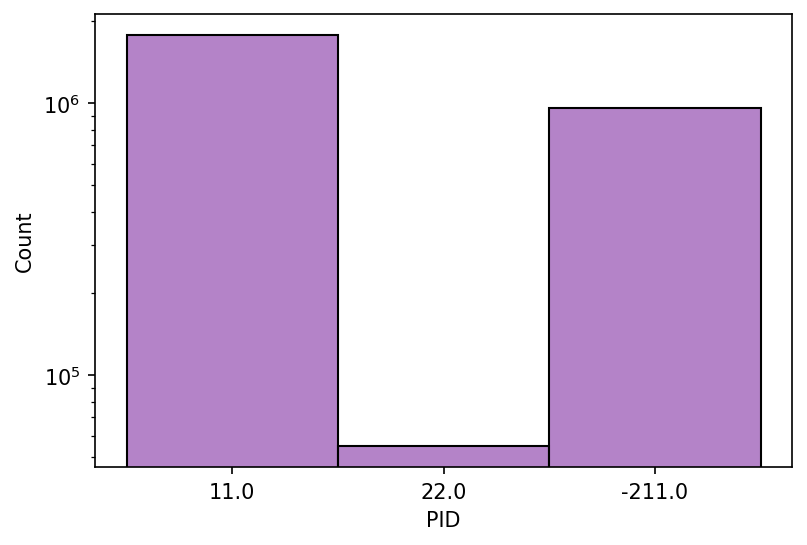

In [4]:
plt.figure(dpi=150)
plt.xlabel("PID")
sns.histplot(sim_df[raw_sim_df["Npesum"]>0], x=sim_df[raw_sim_df["Npesum"]>0]["pid"].astype(str))#, weights="# rate")
plt.yscale("log")


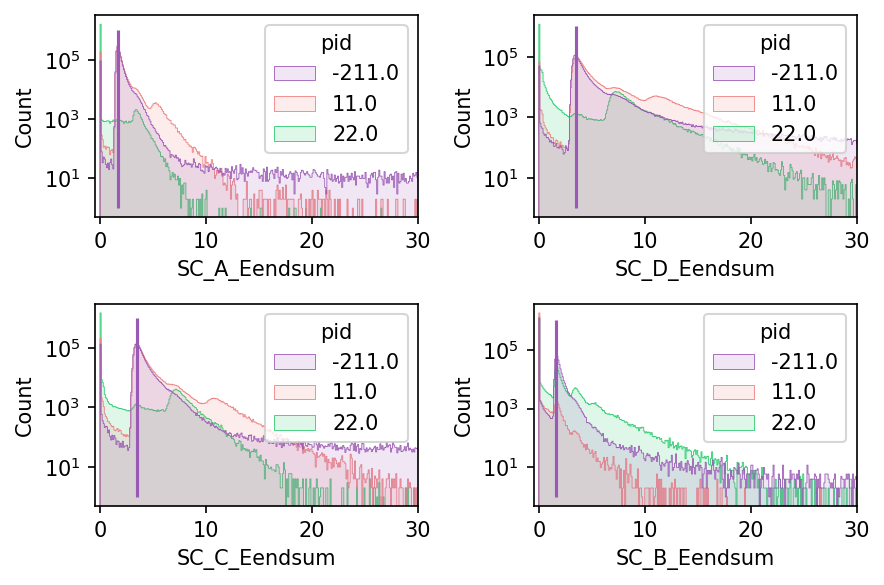

In [5]:
plt.figure(dpi=150)
Scint_MIPs = [1.65, 3.5, 3.5, 1.65] # A, D, C, B

for i in range(4):
    plt.subplot(2,2,i+1)
    sns.histplot(sim_df, x=sim_df.columns[3*i+24], hue="pid", element="step", binwidth=.1, #weights="rate",
                 linewidth=.4, palette=sns.color_palette(best_colors[:-5]), alpha=0.15, legend=1)
    plt.vlines(Scint_MIPs[i],1,10**6)
    plt.yscale("log")
    plt.xlim(-.5,30)
    #plt.xticks(np.arange(0,31,2), minor=1)
    
plt.tight_layout()

## Samples

#MIP Peak Values
Scint_MIPs = [1.65, 1.65, 3.5, 3.5]
Shower_MIP = 37.5#[37.5,37.5,37.5,37.5]

#Assuming SC-threshold @ half-MIP to start, then will get more precise values later

#TS1 - CherSum
TS1_Sim = all_sim[all_sim["Npesum"]>=2].copy()
TS1_Sim["Trig"] = "TS1"

#TS2 - SC-B & SC-D
TS2_Sim = all_sim[(all_sim["SC_B_Eendsum"]>Scint_MIPs[1]/2) & (all_sim["SC_D_Eendsum"]>Scint_MIPs[3]/2)].copy()
TS2_Sim["Trig"] = "TS2"

#TS3 - SC-C & SC-D & ShowerSum (ShSum val is an estimate)
TS3_Sim = all_sim[(all_sim["SC_C_Eendsum"]>Scint_MIPs[2]/2) & (all_sim["SC_D_Eendsum"]>Scint_MIPs[3]/2) & (all_sim["ShowerSum"]>15)].copy()
TS3_Sim["Trig"] = "TS3"

#TS4 - ShowerSum 
TS4_Sim = all_sim[all_sim["ShowerSum"]>200].copy()
TS4_Sim["Trig"] = "TS4"

In [42]:
(keeps & trig_keeps).sum()

2168079

In [98]:
sim_df.columns[[15,16,17,18, 19,20,21,22, 24,27,30,33, 39, 41,47,53,59, -3,-1]]

Index(['PreShSum', 'PreSh_l', 'PreSh_r', 'PreSh_t', 'ShowerSum', 'Shower_l',
       'Shower_r', 'Shower_t', 'SC_A_Eendsum', 'SC_D_Eendsum', 'SC_C_Eendsum',
       'SC_B_Eendsum', 'LASPD_Eendsum', 'GEM00_n', 'GEM10_n', 'GEM01_n',
       'GEM11_n', 'Npesum', 'NCh'],
      dtype='object')

In [88]:
%%time
#Number of background events per data event
n_bkg = 1#00

Scint_MIPs = [1.65, 3.5, 3.5, 1.65] # A, D, C, B

keeps = ((sim_df["pid"]==11) 
         | ((sim_df["pid"]==-211) & (sim_df["p"]<5))
         | ((sim_df["pid"]==22) & (sim_df["p"]<5))
        )


trig_keeps = ((sim_df["SC_A_Eendsum"]>Scint_MIPs[0]/2) 
              & (sim_df["SC_D_Eendsum"]>Scint_MIPs[1]/2) 
              & (sim_df["ShowerSum"]>.5))
"""

Sh_MIP = 37.5
trig_keeps = ((sim_df["Npesum"]>2) 
              & (sim_df["ShowerSum"]>2*Sh_MIP)
             )
"""


#data_np = sim_cher[keeps].to_numpy() #Cher Channels
data_np = sim_df[keeps & trig_keeps].to_numpy() #.sample(n=int(1e5), weights=(sim_df["pid"][keeps & trig_keeps]**6).values)
#bkg_np = ((raw_bkg_df.sample(n=n_bkg*len(data_np), random_state=42, replace=1)).to_numpy()).reshape((len(data_np),-1,len(raw_bkg_df.columns))).sum(axis=1)
#cher_np = Cher_df.to_numpy()

X = data_np[:,[15,16,17,18, 19,20,21,22, 24,27,30,33, 39, 41,47,53,59, -3,-1]] #Baseline
#X = data_np[:,[15,16,17,18, 19,20,21,22]] #ECal
#X = data_np[:,[-3,-1]] #Cher

X_bkg = np.random.randint(0,1,size=(len(X),16))
#X = data_np[:,[0, 15,16,17,18, 19,20,21,22, 24,27,30,33, 39, 41,47,53,59, -3,-1]] #No clustering
#X_bkg = bkg_np[:,[0, 15,16,17,18, 19,20,21,22, 24,27,30,33, 39, 41,47,53,59, -2,-1]]

#X = data_np[:,[0, 15,16,17,18, 19,20,21,22, 24,27,30,33, 39, 41,47,53,59, -7,-5, -4,-3, -2,-1]] #With clustering
#X_Cher = cher_np[:,np.arange(0,16,1)]

#Full_X = np.column_stack([X,X_Cher])

Full_X = X #+ X_bkg

#Get Labels
#y = data_np[:,-1].astype(int)
y = data_np[:,8].astype(int)
y[y==11] = 0
#y += np.round(np.random.uniform(0,1,len(y))).astype(int)
#y[y==22] = 0
y[y==-211] = 1
y[y==22] = 2

scaler = MinMaxScaler()
data = scaler.fit_transform(Full_X)
#data = Full_X/np.max(Full_X)

# print(data.min(), data.max())

#train_data, test_data, train_labels, test_labels = train_test_split(data[:, :-1], data[:, -1], test_size=0.25, random_state=42)
train_data, test_data, train_labels, test_labels = train_test_split(data, y, test_size=0.3, random_state=42)

print("Train:", len(train_data))
print("Test:", len(test_data))

Train: 1530221
Test: 655810
CPU times: user 2.24 s, sys: 2.77 s, total: 5.01 s
Wall time: 4.75 s


In [89]:
np.unique(y, return_counts=1)

(array([0, 1, 2]), array([1630933,  537146,   17952]))

## Model

In [90]:
model = tf.keras.Sequential([
    Input(data.shape[-1]),
    #Dense(1024, activation="relu"), BatchNormalization(), Dropout(0.15),
    Dense(512, activation="relu"), BatchNormalization(), Dropout(0.15),
    Dense(256, activation="relu"), BatchNormalization(), Dropout(0.15),
    Dense(128, activation="relu"), BatchNormalization(), Dropout(0.15),
    Dense(64, activation="relu"), BatchNormalization(), Dropout(0.15),
    Dense(32, activation="relu"), BatchNormalization(), Dropout(0.15),
    Dense(16, activation="relu"), BatchNormalization(), Dropout(0.15),
    Dense(8, activation="relu"), BatchNormalization(), Dropout(0.15),
    Dense(len(np.unique(y)), activation="softmax")
])

model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_56 (Dense)             (None, 512)               10240     
_________________________________________________________________
batch_normalization_49 (Batc (None, 512)               2048      
_________________________________________________________________
dropout_49 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_57 (Dense)             (None, 256)               131328    
_________________________________________________________________
batch_normalization_50 (Batc (None, 256)               1024      
_________________________________________________________________
dropout_50 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_58 (Dense)             (None, 128)              

In [91]:
opt = tf.keras.optimizers.Adam(learning_rate=1e-3)

model.compile(optimizer=opt,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),#from_logits=True),
              metrics=['accuracy'])

## Training

In [92]:
%%time

version = "SULI_Week9_Pencil_TS3_3Part"

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', min_delta=.01, factor=0.9, patience=5, min_lr=1e-5)
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=10) #use 1e-4, 10
un_cts = np.unique(y, return_counts=1)

history = model.fit(train_data, train_labels, batch_size=2000, epochs=50,
                    #class_weight = {int(un_cts[0][0]):1/un_cts[1][0], int(un_cts[0][1]):1/un_cts[1][1], int(un_cts[0][2]):1/un_cts[1][2]},
                    #{0:1.5, 1:30, 2:8}, #{0:10, 1:1, 2:10, 3:1}, #{0:1.5, 1:30, 2:8
                    #sample_weight = np.abs((train_labels-1.3)**-1),#train_labels,
                    callbacks=[reduce_lr,early_stop],
                    validation_data=(test_data, test_labels))


Epoch 1/50
2989/2989 [==============================] - 35s 11ms/step - loss: 0.0383 - accuracy: 0.9919 - val_loss: 0.0138 - val_accuracy: 0.9975
Epoch 2/50
2989/2989 [==============================] - 33s 11ms/step - loss: 0.0059 - accuracy: 0.9989 - val_loss: 0.0034 - val_accuracy: 0.9993
Epoch 3/50
2989/2989 [==============================] - 33s 11ms/step - loss: 0.0046 - accuracy: 0.9991 - val_loss: 0.0029 - val_accuracy: 0.9994
Epoch 4/50
2989/2989 [==============================] - 33s 11ms/step - loss: 0.0040 - accuracy: 0.9992 - val_loss: 0.0033 - val_accuracy: 0.9994
Epoch 5/50
2989/2989 [==============================] - 33s 11ms/step - loss: 0.0035 - accuracy: 0.9993 - val_loss: 0.0032 - val_accuracy: 0.9993
Epoch 6/50
2989/2989 [==============================] - 33s 11ms/step - loss: 0.0032 - accuracy: 0.9993 - val_loss: 0.0073 - val_accuracy: 0.9984
Epoch 7/50
2989/2989 [==============================] - 33s 11ms/step - loss: 0.0030 - accuracy: 0.9994 - val_loss: 0.0025 -

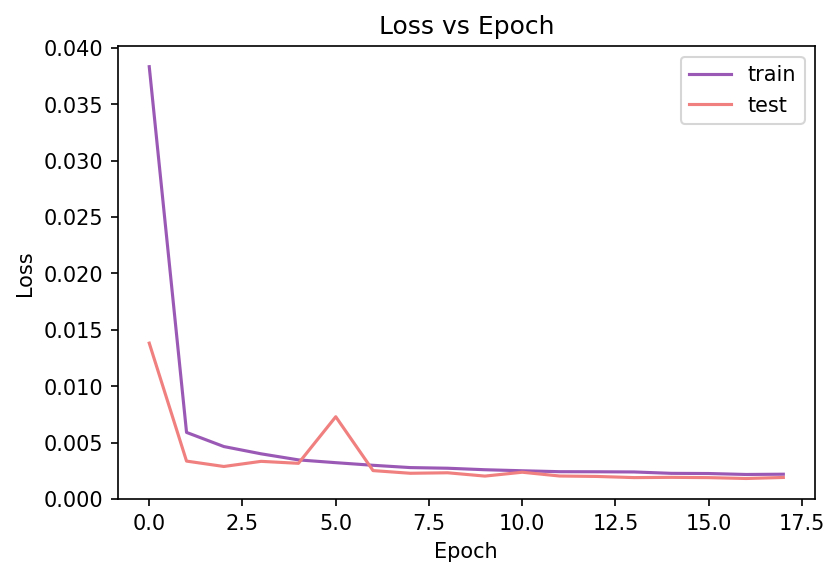

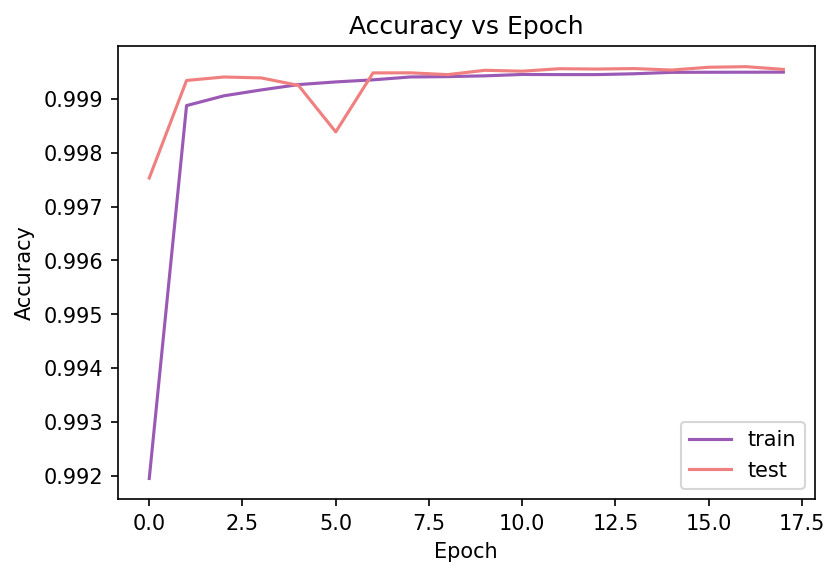

In [93]:
plt.figure(dpi=150)
plt.title("Loss vs Epoch")
plt.ylabel("Loss")
plt.xlabel("Epoch")

plt.plot(np.arange(len(history.history["loss"])),history.history["loss"], label="train")
plt.plot(np.arange(len(history.history["val_loss"])),history.history["val_loss"], label="test")
plt.legend()
plt.savefig(f"Plots/TrainingPlots/Sim_Loss_{version}.pdf")
plt.show()

plt.figure(dpi=150)
plt.title("Accuracy vs Epoch")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")

plt.plot(np.arange(len(history.history["accuracy"])),history.history["accuracy"], label="train")
plt.plot(np.arange(len(history.history["val_accuracy"])),history.history["val_accuracy"], label="test")
plt.legend()
plt.savefig(f"Plots/TrainingPlots/Sim_Accuracy_{version}.pdf")
plt.show()

In [94]:
%%time

##Save Model
tf.keras.models.save_model(model,f"Models/{version}/Model")
model.save_weights(f"Models/{version}/Weights")
 
# load model
tf.keras.models.load_model(f"Models/{version}/Model").summary()
savedModel = model.load_weights(f"Models/{version}/Weights")

INFO:tensorflow:Assets written to: Models/SULI_Week9_Pencil_TS3_3Part/Model/assets
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_56 (Dense)             (None, 512)               10240     
_________________________________________________________________
batch_normalization_49 (Batc (None, 512)               2048      
_________________________________________________________________
dropout_49 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_57 (Dense)             (None, 256)               131328    
_________________________________________________________________
batch_normalization_50 (Batc (None, 256)               1024      
_________________________________________________________________
dropout_50 (Dropout)         (None, 256)               0         
_____________________________________

## Confusion Matrices

CPU times: user 56 s, sys: 8 s, total: 1min 4s
Wall time: 24.1 s


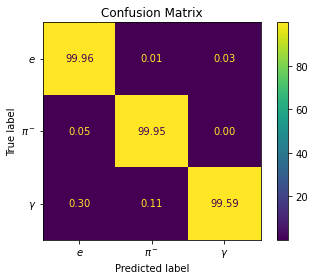

In [95]:
%%time

probability_model = model

predictions = probability_model.predict(test_data)
results = np.argmax(predictions, axis=1)

#e_eff = ((results==0)*(test_labels==0)).sum()/(test_labels==0).sum()
#pi_rej = 1-(((results==0)*(test_labels==2)).sum()/(test_labels==2).sum())

#print("e Efficiency:",e_eff)
#print("Pi Rejection:",pi_rej)

cm= confusion_matrix(test_labels,results)#, sample_weight=test_data[:,0])
cm_percent = (cm)/(np.repeat(cm.sum(axis=1),3,axis=0).reshape(3,3))*100
disp = ConfusionMatrixDisplay(confusion_matrix=cm_percent,display_labels=["$e$","$\pi^-$", "$\gamma$"])#[11,22,211]) #"$\gamma$",
disp.plot(values_format='.2f')

plt.title(f"Confusion Matrix")#: $e$:{e_eff*100: .1f}% & $\pi$:{pi_rej*100: .1f}%")

plt.savefig(f"Plots/ConfusionPlots/Sim_Confusion_{version}.pdf")



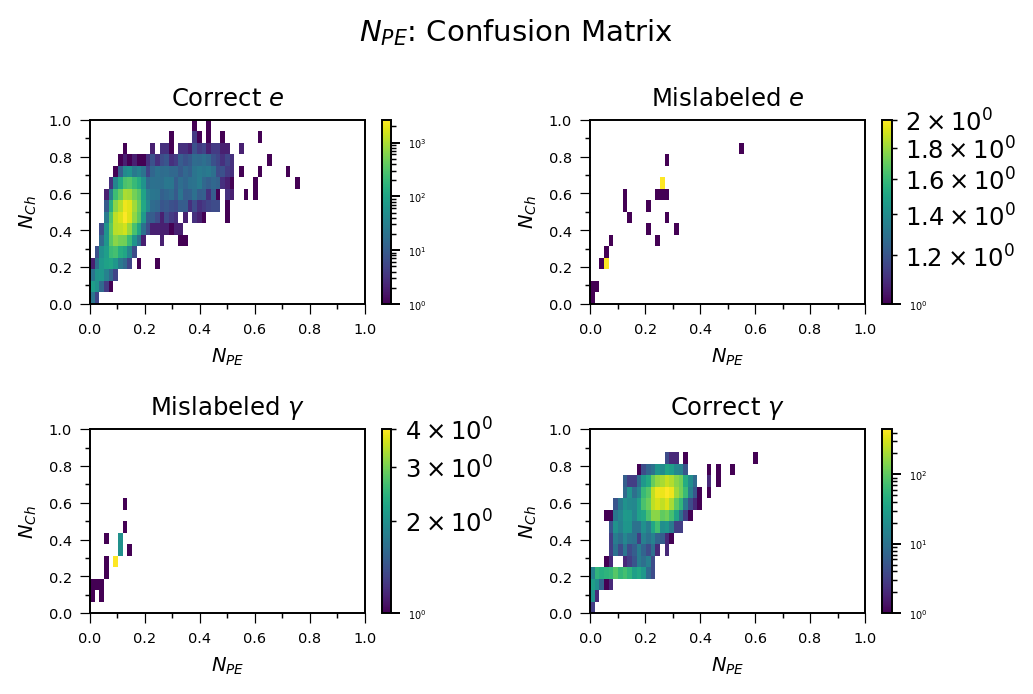

In [55]:
"""
labels = ["Correct $e$", "Mislabeled $e$", "Mislabeled $\pi^-$", "Correct $\pi^-$"]    
    
fig, axes = plt.subplots(2, 2, dpi=175)    
plt.suptitle("ECal: Confusion Matrix")

for j in range(4):

    #plt.subplot(2,2,i+1)
    axes[int(j/2),j%2].set_title(labels[j], fontsize=10)
    axes[int(j/2),j%2].set_xlabel("ShowerSum", fontsize=8)
    axes[int(j/2),j%2].set_ylabel("PreShSum", fontsize=8)

    keeps = (test_labels==int(j/2)) & (results==j%2)
    axes[int(j/2),j%2].hist2d(test_data[:,4][keeps], test_data[:,1][keeps], bins=np.arange(0,1.001,.01), norm=LogNorm())

    #cbar = plt.colorbar(image, ax=axes[int(j/2),j%2])
    #cbar.ax.tick_params(labelsize=4)
    
    axes[int(j/2),j%2].set_xticks(np.arange(0,1.01,.2))#, fontsize=4)
    axes[int(j/2),j%2].set_xticks(np.arange(0,1.01,.1), minor=1)
        
    axes[int(j/2),j%2].set_yticks(np.arange(0,1.01,.2))#, fontsize=4)
    axes[int(j/2),j%2].set_yticks(np.arange(0,1.01,.1), minor=1)
    
    axes[int(j/2),j%2].tick_params(labelsize=6, length=4, width=0.5)

plt.tight_layout()
plt.savefig(f"Plots/ConfusionPlots/ECal_Confusion_{version}.pdf")
plt.show()
"""

part2 = "gamma"
labels = ["Correct $e$", "Mislabeled $e$", f"Mislabeled $\{part2}$", f"Correct $\{part2}$"]    
    
fig, axes = plt.subplots(2, 2, dpi=175)    
plt.suptitle("$N_{PE}$: Confusion Matrix")

for j in range(4):

    #plt.subplot(2,2,i+1)
    axes[int(j/2),j%2].set_title(labels[j], fontsize=10)
    axes[int(j/2),j%2].set_xlabel("$N_{PE}$", fontsize=8)
    axes[int(j/2),j%2].set_ylabel("$N_{Ch}$", fontsize=8)

    keeps = (test_labels==int(j/2)) & (results==j%2)
    h, xedges, yedges, image = axes[int(j/2),j%2].hist2d(test_data[:,-2][keeps], test_data[:,-1][keeps],
                                                         bins=(np.linspace(0,1.001,60),np.linspace(0,1.001,17)), norm=LogNorm())
    
    cbar = plt.colorbar(image, ax=axes[int(j/2),j%2])
    cbar.ax.tick_params(labelsize=4)
    
    axes[int(j/2),j%2].set_xticks(np.arange(0,1.1,.2))#, fontsize=4)
    axes[int(j/2),j%2].set_xticks(np.arange(0,1.1,.1), minor=1)
    
    axes[int(j/2),j%2].set_yticks(np.arange(0,1.1,.2))#, fontsize=4)
    axes[int(j/2),j%2].set_yticks(np.arange(0,1.1,.1), minor=1)
    
    axes[int(j/2),j%2].tick_params(labelsize=6, length=4, width=0.5)

plt.tight_layout()
plt.savefig(f"Plots/ConfusionPlots/NPE_NCh_Confusion_{version}.pdf")
plt.show()


# Comapre Models

In [79]:
def get_eff_rej(predictions, test_labels, e_pid=0, intervals=1000, low_lim=0.4):
    spacing = .0001
    #prob_limits = np.arange(.40,1, spacing)
    prob_limits = np.linspace(low_lim,1, int(intervals))
    #prob_limits = np.logspace(-.5,0, int(3e4))
    
    #Get Events
    e_events = (test_labels==e_pid)
    pi_events = (test_labels!=e_pid)
    
    #Get Nums
    num_e = (test_labels==e_pid).sum()
    num_pi = (test_labels!=e_pid).sum()

    true_e, false_e = [], []
    for p_val in prob_limits:
        pids = predictions[:,0]>p_val

        true_e.append(((pids==e_pid)*e_events).sum()/num_e)
        false_e.append(((pids==e_pid)*pi_events).sum()/num_pi)
    
    return np.array(true_e), np.array(false_e)

#GeV6_true_e, GeV6_false_e = get_eff_rej(GeV6_predictions, test_labels)

In [113]:
%%time
#ECal_predictions = model.predict(test_data)
#ECal_true_e, ECal_false_e = get_eff_rej(ECal_predictions, test_labels, intervals=3e4, low_lim=.01)
#np.savetxt('ML_Probs/TrigTest/ML_ECal_TS3_MomCut1GeV.out', np.column_stack([ECal_true_e, ECal_false_e]), delimiter=',')

#Cher_predictions = model.predict(test_data)
#Cher_true_e, Cher_false_e = get_eff_rej(Cher_predictions, test_labels, intervals=3e4, low_lim=.01)
#np.savetxt('ML_Probs/TrigTest/ML_Cher_TS3_MomCut1GeV.out', np.column_stack([Cher_true_e, Cher_false_e]), delimiter=',')

#Both_predictions = ECal_predictions*Cher_predictions
#Both_true_e, Both_false_e = get_eff_rej((Both_predictions/(Both_predictions.sum(axis=1))[:,None]), 
#                                        test_labels, intervals=3e4, low_lim=.01)
np.savetxt('ML_Probs/TrigTest/ML_Combined_TS3_MomCut1GeV.out', np.column_stack([Both_true_e, Both_false_e]), delimiter=',')



CPU times: user 83 ms, sys: 0 ns, total: 83 ms
Wall time: 81.9 ms


/tmp/ipykernel_296384/1310634306.py:9: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(1/(1-ECal_false_e),1-ECal_true_e, label="ECal")
/tmp/ipykernel_296384/1310634306.py:10: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(1/(1-Cher_false_e),1-Cher_true_e, label="Cher")
/tmp/ipykernel_296384/1310634306.py:11: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(1/(1-Both_false_e),1-Both_true_e, label="Combined")


[]

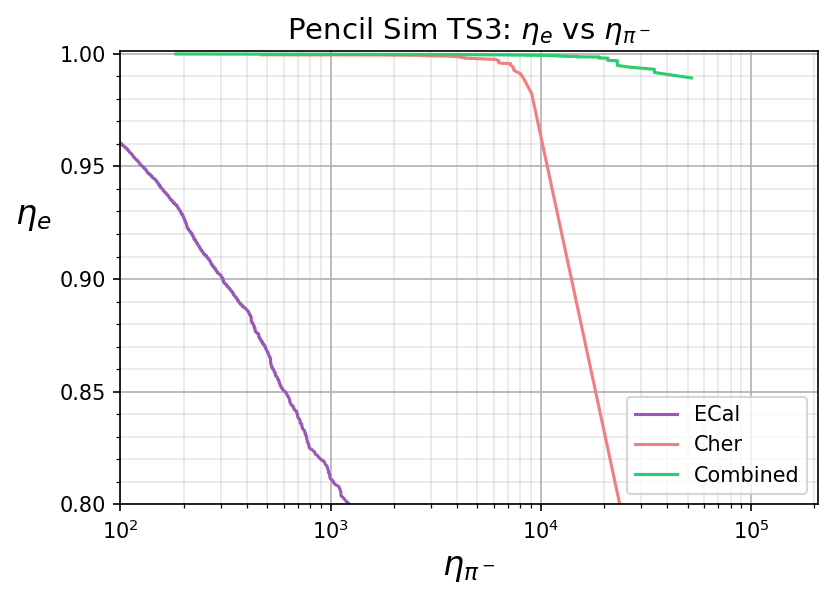

In [115]:
fig, ax = plt.subplots(dpi=150)
plt.title("Pencil Sim TS3: $\eta_e$ vs $\eta_{\pi^-}$", fontsize=14)
plt.ylabel("$\eta_e$",rotation=0, fontsize=16)
ax.yaxis.set_label_coords(-.125, .6)
#plt.xlabel("$\pi^-$ Rejection")
plt.xlabel("$\eta_{\pi^-}$", fontsize=16)

#plt.plot(1/(1-baseline_false_e),1-baseline_true_e, label="baseline", c="#9b59b6")
plt.plot(1/(1-ECal_false_e),1-ECal_true_e, label="ECal")
plt.plot(1/(1-Cher_false_e),1-Cher_true_e, label="Cher")
plt.plot(1/(1-Both_false_e),1-Both_true_e, label="Combined")


#get handles and labels
#handles, labels = plt.gca().get_legend_handles_labels()

#specify order of items in legend
#order = [2,4,0,1,3,5,6]

#add legend to plot
plt.legend()#[handles[idx] for idx in order],[labels[idx] for idx in order])

#ax.set_xticks(np.arange(0,501,25), minor=1)
ax.set_yticks(np.arange(0.80,1.1,.05))
ax.set_yticks(np.arange(0.80,1.1,.01), minor=1)

plt.xlim(1e2,(test_labels==1).sum())#1e6)
plt.ylim(0.80,1.001)

plt.xscale("log")
#plt.yscale("log")

plt.grid()
plt.grid(axis="both", which="minor", alpha=0.3)

plt.savefig("Plots/ModelCompare_eEff_PiRej_Pencil_TS3.pdf")
#plt.savefig("Plots/ModelCompare_eEff_PiRej_Pencil_Cher_ECal.pdf")
#plt.savefig("Plots/ModelCompare_eEff_PiRej_Pencil_Cher_ECal_log.pdf")

plt.plot()